**Découverte jeux de données**

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# ACP
import sklearn.decomposition as sd
import sklearn.preprocessing as sp
# FFT
from scipy.fftpack import fft

# Plot et Display
from IPython.display import display
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sb
sb.set()
sb.set_style("whitegrid")


In [57]:
path = "../Donnees_projet/Ensemble_apprentissage/"
path = "../Donnees_projet/Ensemble_de_test/"

In [90]:
files = os.listdir(path)
nb_series = len(files)
print(nb_series)

128


In [166]:
serie_1 = pd.read_csv(path + files[0], index_col=0)
serie_1.tail(10)
seuil_pic = 10

,TIMESTAMP,FF_1
618,2013-02-21T20:50:10.505,3080.0
619,2013-02-21T20:50:11.505,3592.0
620,2013-02-21T20:50:12.505,3952.0
621,2013-02-21T20:50:13.505,4176.0
622,2013-02-21T20:50:14.505,4568.0
623,2013-02-21T20:50:15.505,5144.0
624,2013-02-21T20:50:16.505,5480.0
625,2013-02-21T20:50:17.505,6264.0
626,2013-02-21T20:50:18.505,8504.0
627,2013-02-21T20:50:19.505,13632.0


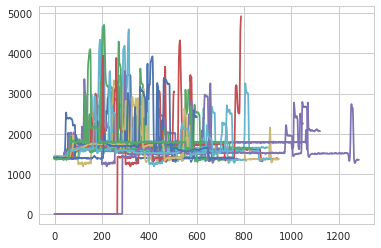

In [168]:
for i in range(0,50) :
    data = enlever_pic(pd.read_csv(path + files[i]), seuil_pic)
    plt.plot(data["FF_1"][:-20])
plt.show()

Longueur des séries :

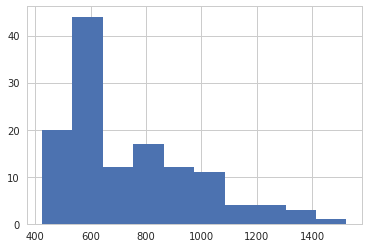

In [61]:
long = [pd.read_csv(path + file).shape[0] for file in files]
plt.hist(long)
plt.show()

Idée : vstack les signaux puis parcourir pour attraper les coeffs de Fourier

In [76]:
X_signal = [list(pd.read_csv(path + files[num])["FF_1"][:-20]) for num in range(nb_series)]
#print(X_signal)  # On a une liste de listes, chaque liste est une série de données

In [77]:
fftCoeff = []

for x in X_signal :
    #plt.plot(x)
    #plt.show()
    mx = np.mean(x)
    x_centre = x - mx
   #Apply fast Fourier transform
    coeffsfft = np.abs(fft(x_centre))  
    coeffsfft_flatten = np.hstack(coeffsfft)
    fftCoeff.append(coeffsfft_flatten)
        
fftCoeff = np.array(fftCoeff)

# Il suffit de garder la moitié des coefficients (ils sont ensuite répétés  de manière symétrique)

fftCoeff=fftCoeff[:][:len(fftCoeff//2)]
print(fftCoeff.shape)
print(np.sum(fftCoeff!=0))

(128,)
1


/usr/local/insa/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.


Problème : toutes les séries font pas la même longueur, donc faut seuiller pour en garder un nombre fixe. On teste en en gardant autant que possible, ie autant que la longueur de la plus longue série. Pour les autres, on garde les plus grands coefficients ordonnés.

In [78]:
longueur_max = min([len(x) for x in fftCoeff])

In [79]:
print(np.array(fftCoeff[0]))

[2.13731255e-11 1.20672793e+05 5.91698620e+04 2.68311132e+04
 2.79586717e+04 4.89498693e+04 4.93433550e+04 3.66701623e+04
 6.21602569e+04 5.79008622e+04 4.94408498e+04 1.73880841e+04
 2.35902605e+04 4.81170738e+04 2.72388842e+04 2.95552371e+04
 3.64953356e+03 1.30230025e+04 1.30665027e+04 1.50467503e+04
 1.20168648e+04 7.37115980e+03 1.47877486e+04 6.96605346e+03
 1.16100714e+04 5.93661594e+03 6.62081000e+03 1.12903984e+04
 4.70569631e+03 7.72137394e+03 5.02083023e+03 7.50382817e+03
 4.89436611e+03 8.10382348e+03 2.21871493e+03 5.24724566e+03
 5.13439523e+03 7.86584191e+03 4.37380323e+03 5.27266956e+03
 2.86699497e+03 2.77002539e+03 1.74199634e+03 3.45299583e+03
 1.54106043e+03 4.66140984e+03 5.60858157e+03 4.65242025e+03
 6.33444421e+03 3.95295287e+03 1.05233366e+03 3.46202241e+03
 1.33233428e+03 4.17613243e+03 2.83111222e+03 5.16360622e+03
 4.64160100e+03 5.13000879e+03 3.85776860e+02 3.22254906e+03
 2.07541345e+03 3.26124691e+03 2.68372197e+03 3.83830324e+03
 2.78351160e+03 2.902224

In [80]:
liste = [1,10,2,30,25,3,58,0,24,20,7]
print(liste)
seuil = [x for x in liste if x >= np.sort(liste)[-5]]
print(seuil)

[1, 10, 2, 30, 25, 3, 58, 0, 24, 20, 7]
[30, 25, 58, 24, 20]


In [81]:
coeffs_seuil = np.zeros((0, longueur_max))

for coeffs in fftCoeff :
    c = [x for x in coeffs if x >= np.sort(coeffs)[-longueur_max]][:longueur_max]
    coeffs_seuil = np.vstack((coeffs_seuil, c))

In [82]:
acp = sd.PCA()
X_acp_fft = acp.fit_transform(sp.scale(coeffs_seuil))


Text(0.5,1,'Distribution des premieres composantes')

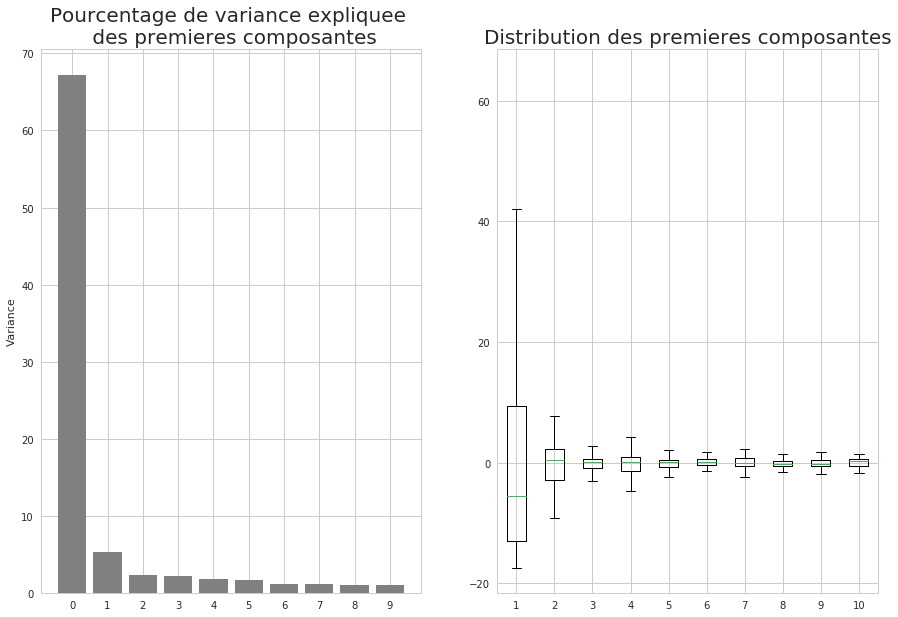

In [83]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1,2,1)
ax.bar(range(10), acp.explained_variance_ratio_[:10]*100, align='center',
        color='grey', ecolor='black')
ax.set_xticks(range(10))
ax.set_ylabel("Variance")
ax.set_title("Pourcentage de variance expliquee \n des premieres composantes", fontsize=20)

ax = fig.add_subplot(1,2,2)
box=ax.boxplot(X_acp_fft[:,0:10])
ax.set_title("Distribution des premieres composantes", fontsize=20)

No handles with labels found to put in legend.


Text(0.5,1,'Projection des features sur les \n  deux premieres composantes')

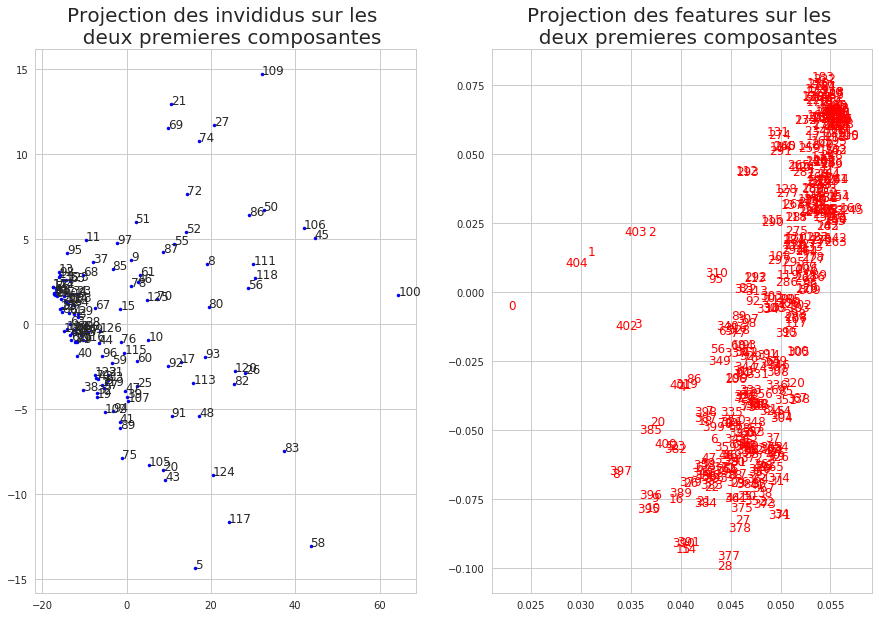

In [84]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1,2,1)
labels=[]
for x,y,s in zip(X_acp_fft[:,0], X_acp_fft[:,1], map(str,range(longueur_max))):
    ax.plot(x,y,marker=".", color="blue")
    ax.text(x, y, s)
       
plt.legend(fontsize=15)
ax.set_title("Projection des invididus sur les \n  deux premieres composantes", fontsize=20)


ax = fig.add_subplot(1,2,2)
for x,y,s in zip(acp.components_[0], acp.components_[1], map(str,range(longueur_max))):
    ax.text(x,y,s, horizontalalignment="center", verticalalignment="center", color="red")
    
ax.set_xlim(acp.components_[0].min()-0.002,acp.components_[0].max()+0.002)
ax.set_ylim(acp.components_[1].min()-0.01,acp.components_[1].max()+0.01)
ax.set_title("Projection des features sur les \n  deux premieres composantes", fontsize=20)


Est-ce que c'est bien légal de garder les plus grands pour chaque série, qui ne sont pas forcément aux mêmes positions ?  Solution 1 : garder que les premiers. Ca veut plus dire grand chose visiblement.

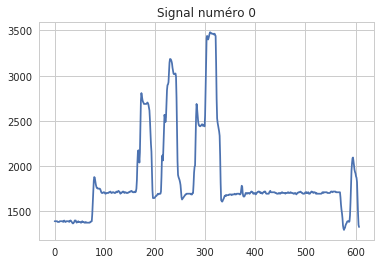

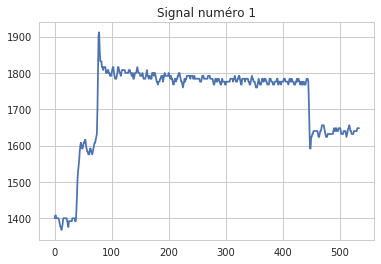

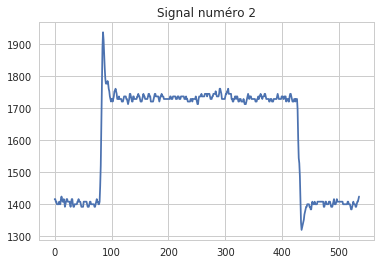

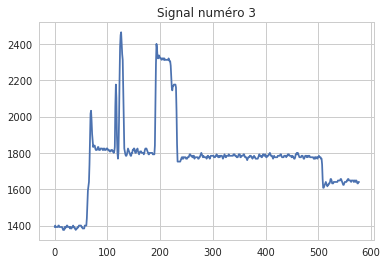

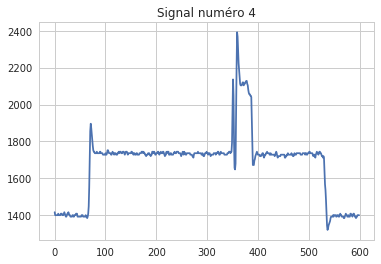

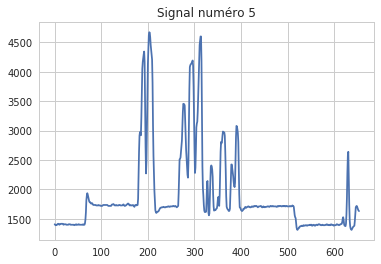

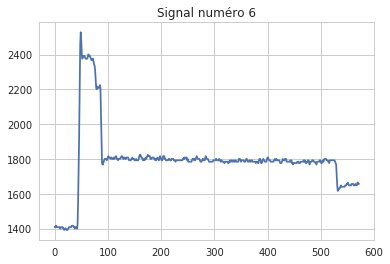

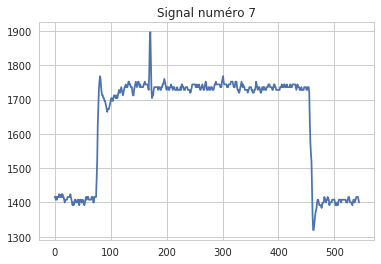

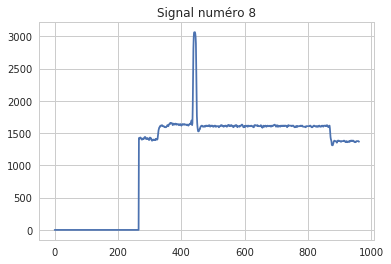

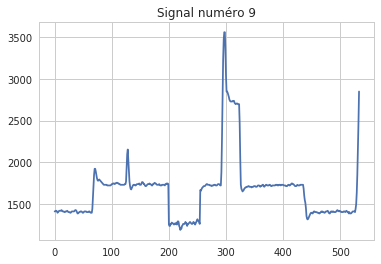

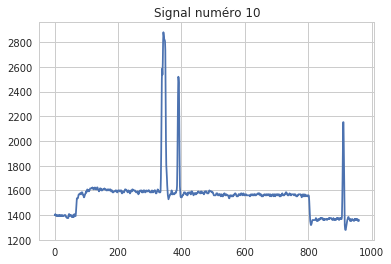

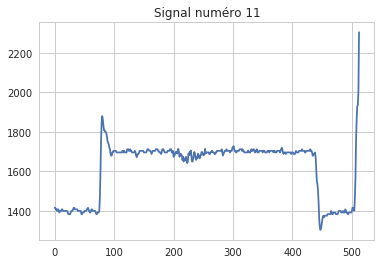

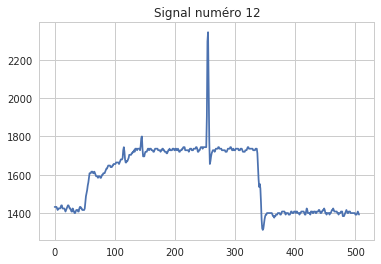

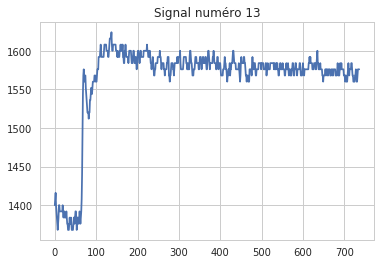

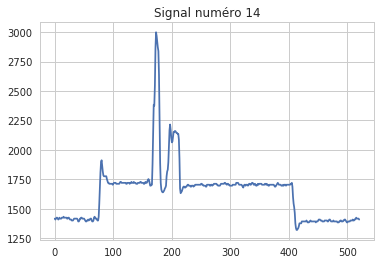

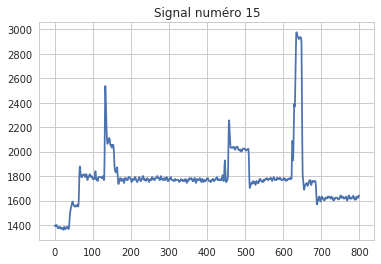

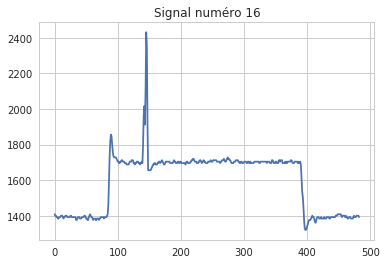

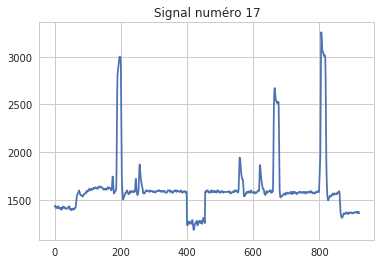

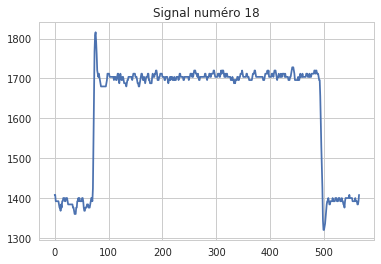

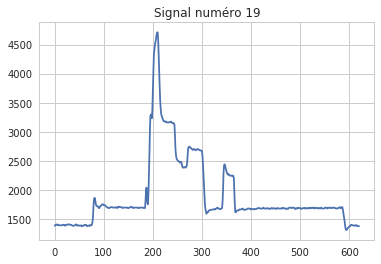

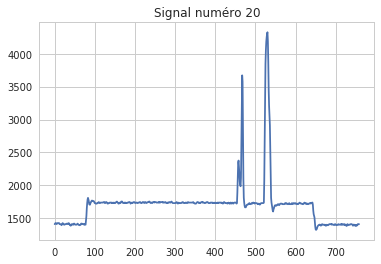

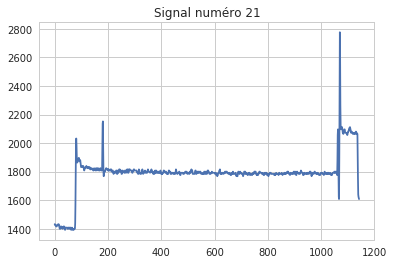

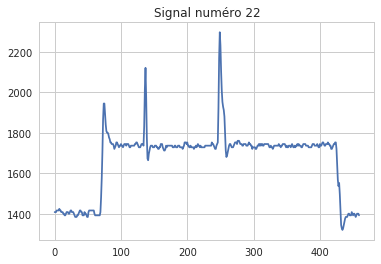

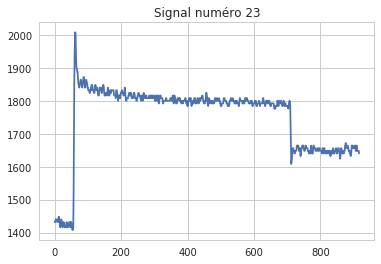

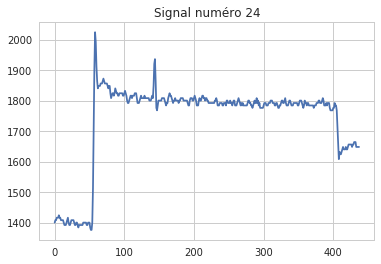

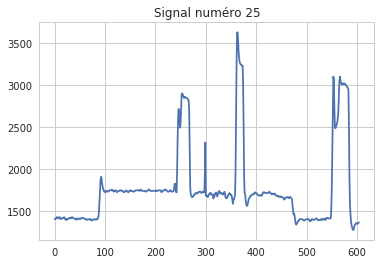

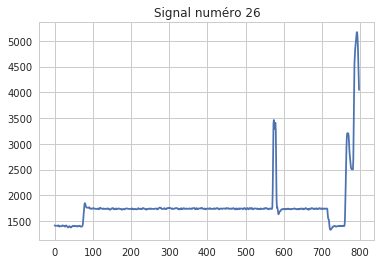

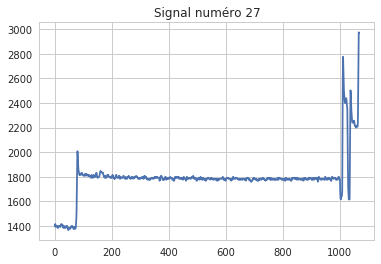

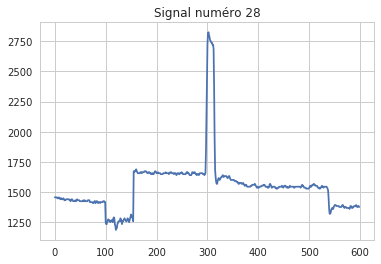

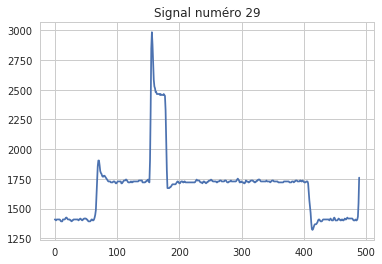

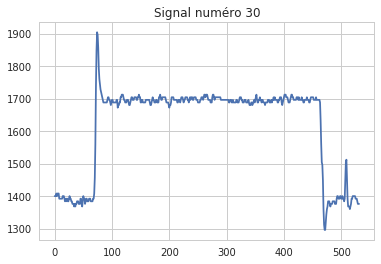

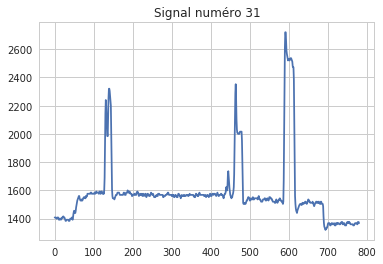

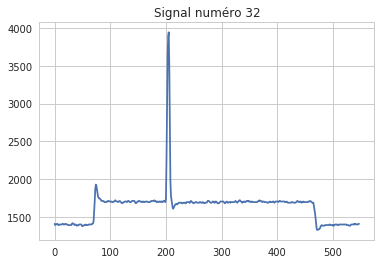

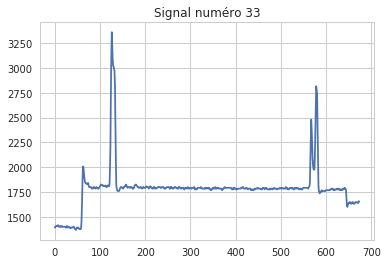

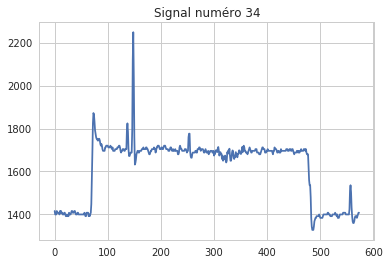

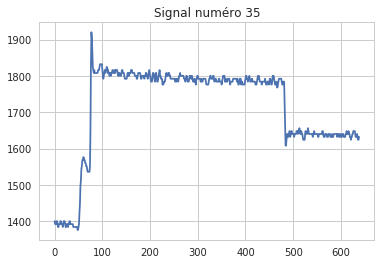

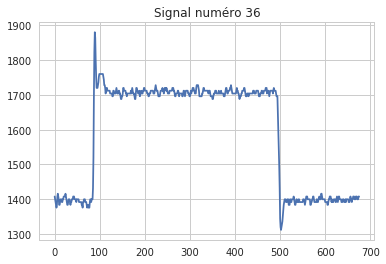

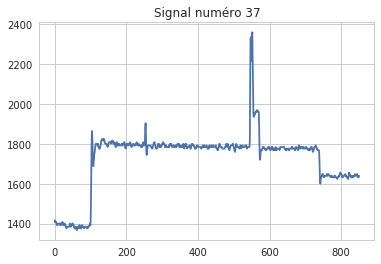

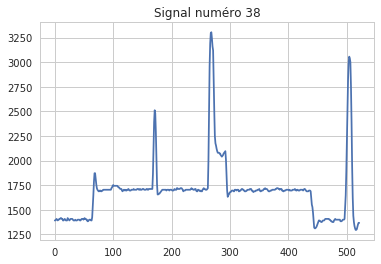

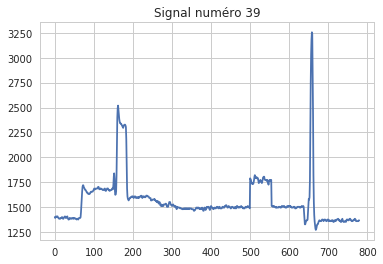

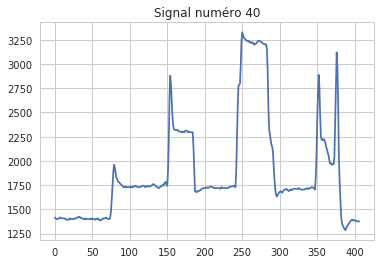

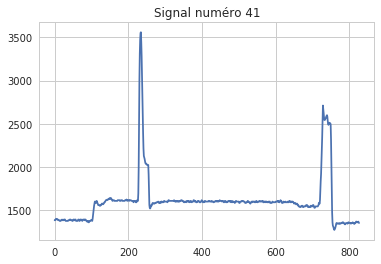

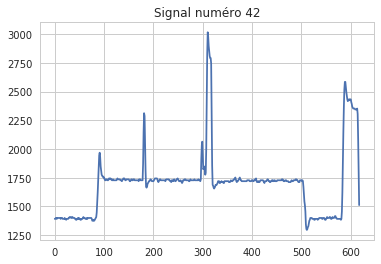

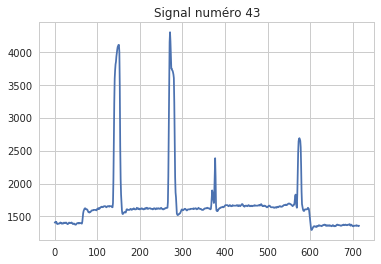

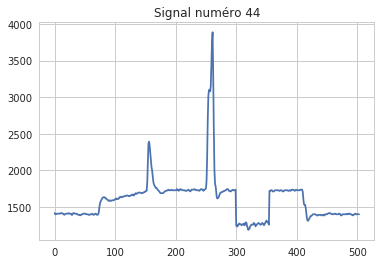

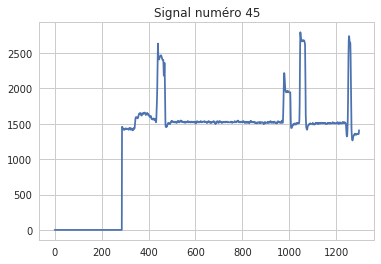

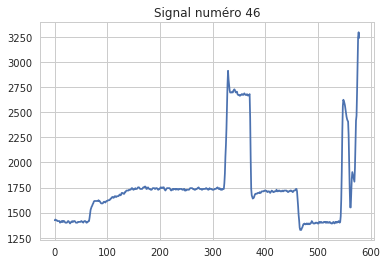

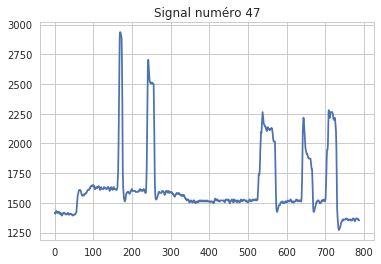

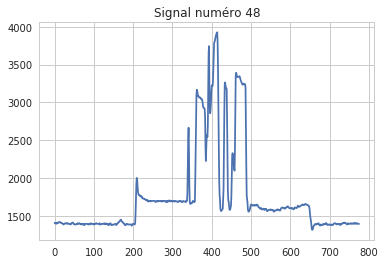

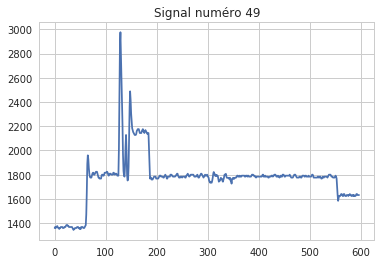

In [92]:
#for num in [124, 61, 217, 244, 113, 62, 109] :
for num in range(50) :
    data = pd.read_csv(path + files[num])[:-20]
    plt.plot(data["FF_1"])
    plt.title("Signal numéro " + str(num))
    plt.show()

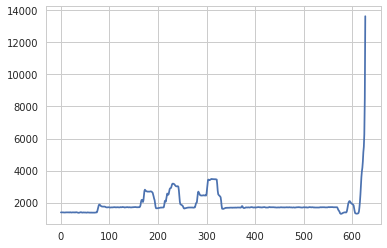

In [152]:
serie_1 = pd.read_csv(path + files[0], index_col=0)
plt.plot(serie_1["FF_1"].values)

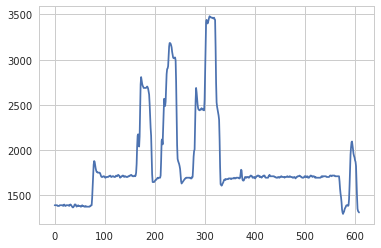

In [163]:
def enlever_pic(serie, seuil) :
    """retire le pic final, le seuil est le plus petit accroissement considéré comme appartenant
    encore au pic 
    Retourne le dataframe tronqué"""
    val_serie = serie["FF_1"].values
    #plt.plot(val_serie)
    accr = val_serie[1:] - val_serie[:-1]
    for ind, val in enumerate(accr[::-1]) :
        if val < seuil_pic :
            #plt.plot(val_serie[:-ind], color="red")
            #plt.show()
            break
    else : 
        print("Alerte pas de pic")
    return serie.drop(serie.index[-ind:])

a = enlever_pic(serie_1, 10)
plt.plot(a["FF_1"].values)
plt.show()